# Práctica Métodos de Simulación - Parte 2

## Elena Rivas, Teresa Grau, Ignacio Casso

**Enunciado. Simulación de sucesos discretos.**

Un taller de fabricación se dedica a procesar tres tipos de piezas, para ello el taller consta de cuatro células de procesamiento.

En el interior de cada célula se dispone de una máquina de procesado, excepto en la célula 3 formada por dos máquinas con las mismas características, y de un almacén (de capacidad ilimitada).

La secuencia de fabricación de cada una de las piezas así como los tiempos de procesado (expresados en minutos y distribuidos según una triangular) en cada célula se muestran en la siguiente tabla:


**TODO:** Escribir tabla usando sintáxis de hml:

| A | B | C |
| --- | --- | --- |
| a | b | c |

Los tiempos entre llegadas de las piezas al taller tiene carácter aleatorio. En el fichero `llegadas.txt` se proporciona una muestra de tiempos entre llegadas de piezas. Contrástese si la distribución de dichos tiempos es normal (truncada), weibull o exponencial y estímense los parámetros de la distribución correspondiente.

El fichero `piezas.txt` incluye un histórico de piezas que han llegado al taller, que nos permitirá identificar la proporción de piezas que hay de cada uno de los tres tipos.

Los tiempos de transporte de cada pieza entre las diferentes células es de 2 minutos.

A. Suponiendo que el taller trabaja de forma ininterrumpida (hay tres turnos de trabajadores), simular el comportamiento del sistema durante 2 meses para estimar el tiempo mínimo, medio y máximo que tardan en fabricarse los tres tipos de piezas, el número medio de piezas esperando en cada una de las 4 células y la proporción de tiempo que están ociosas las máquinas de procesado de las células.

B. Calcular las medidas anteriores si el tiempo de transporte de las piezas entre las distintas células se reduce la mitad.

En caso de que fuese posible disponer de una máquina de procesado adicional, ¿en qué célula sería más beneficioso ponerla?

## Distribución de los tiempos de llegada

En primer lugar comprobamos si los tiempos de llegada proporcionados en el fichero `E1.llegadas.txt` siguen una distribución normal truncada, weibull o exponencial, y estimar los parámetros correspondientes. Para ello podemos usar los contrastes de hipótesis vistos en clase, en concreto el contraste de ***Kolmogorov-Smirnov***.

En estadística, la prueba de *Kolmogórov-Smirnov* (también prueba K-S) es una prueba no paramétrica que determina la bondad de ajuste de dos distribuciones de probabilidad entre sí. Consiste en lo siguiente:

Deseamos contrastar la hipotesis
    $$H_0: F_n(x) = F_0(x)$$

Para ello, utilizamos el estadístico de contraste
 $$D = sup|\hat F_n(x_i) - F_0(x_i)|$$
donde:
* $x_i$ es el i-ésimo valor observado en la muestra (cuyos valores se han ordenado previamente de menor a mayor).
* $\hat F_n(x_i)$ es un estimador de la probabilidad de observar valores menores o iguales que $x_i$.
* $F_0(x_i)$ es la probabilidad de observar valores menores o iguales que $x_i$ cuando $H_0$ es cierta.

Así pues, $D$ es la mayor diferencia absoluta observada entre la frecuencia acumulada observada $\hat F_n(x_i)$ y la frecuencia acumulada teórica $F_0(x_i)$, obtenida a partir de la distribución de probabilidad que se especifica como hipótesis nula.

Si los valores observados $\hat F_n(x_i)$ son similares a los esperados $F_0(x_i)$, el valor de $D$ será pequeño. Cuanto mayor sea la discrepancia entre la distribución empírica $\hat F_n(x_i)$ y la distribución teórica $F_0(x_i)$, mayor será el valor de $D$.

In [3]:
import numpy as np
import random
import queue
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import kstest

In [4]:
archivo_llegadas = open('./E1.llegadas.txt', 'r')
llegadas = [float(line) for line in archivo_llegadas.readlines()]
archivo_llegadas.close()

In [5]:
archivo_piezas = open('./E1.piezas.txt', 'r')
piezas = [int(line) for line in archivo_piezas.readlines()]
archivo_piezas.close()

Con el paquete estadístico `stats` de la librería `scipy` de Python podemos contrastar la distribución de nuestra muestra con la prueba de ***Kolmogorov***.

In [6]:
from scipy.stats import expon, exponweib, truncnorm

middle = len(llegadas)//2 #TODO: no lo usamos

llegadas1, llegadas2 = llegadas[:middle], llegadas[middle:]

Comenzamos testando la distribución exponencial. Según la documentación del paquete `stats`, la función de densidad de la exponencial es:
$$f(x) = \exp(-x)$$ para $x\geq0$.

La densidad de probabilidad anterior se define en la forma "estandarizada". Para cambiar y/o escalar la distribución, utilizamos los parámetros `loc` y `scale`. Específicamente, `expon.pdf (x, loc, scale)` (probability density function), que es equivalente a `expon.pd(y) / scale` con `y = (x - loc) / scale`.

Una parametrización común de la exponencial es en términos del parámetro *lambda*, tal que `pdf = lambda * exp (-lambda * x)`. Esta parametrización corresponde a usar `scale = 1/lambda`.

Para realizar el contraste con la librería `stats` primero necesitamos estimar los parametros que corresponderían a nuestra muestra para la distribución que queremos contrastar. Para esta tarea, `stats` cuenta con el método `scipy.stats.rv_continuous.fit`.

Éste devuelve los *MLE* para los parámetros de forma (si corresponde), ubicación y escala a partir de la muestra. MLE significa Estimación de máxima verosimilitud (Maximum Likelihood Estimate).
Hay que tener en cuenta que `fit` se calcula al maximizar una función *log-likehood*, aplicando una penalización para muestras fuera del rango de distribución. No se garantiza que la respuesta devuelta sea el MLE globalmente óptimo, puede que solo sea óptimo local o la optimización puede fallar por completo.

Una vez estimados los parametros de la exponencial, ya podemos utilizar el método `scipy.stats.kstest` que ejecuta la prueba de Kolmogorov-Smirnov para comprobar la bondad del ajuste. Que devuelve el valor del estadístico $D$ y un ***p-valor***.

La decisión de aceptar o rechazar la hipotesis es tomada a partir de este ***p-valor***. Si el ***p-valor*** es grande significa  que, siendo cierta la hipótesis nula, el valor observado del estadístico $D$ era  esperable, y por tanto, no hay razón para rechazar la hipótesis. Asimismo, si el ***p-valor*** es pequeño, indica que, siendo cierta la hipótesis nula, es muy difícil que se produjera el valor de $D$ que efectivamente se ha observado. Ello obliga a poner muy en duda, y  por tanto a rechazar la hipótesis nula.

Ya podemos testar la distribución exponencial:

In [7]:
loc, scale = expon.fit(llegadas)

# kstest(llegadas, lambda x : expon.cdf(x, loc = loc, scale = scale))

kstest(llegadas,'expon', (loc, scale))

KstestResult(statistic=0.010470714624899208, pvalue=0.64335948653523267)

Hipotesis no rechazada. Los párametros serían:

In [8]:
print((loc, scale))

(0.0011736909087417102, 12.996337543335594)


A continuación testamos la distribución de weibull, que según la documentación de `stats` tiene la siguiente funcion de distribución:
$$f(x,a,c) = ac(1-exp(-x^c))^{a-1}exp(-x^c)^{c-1}$$
para $x>0$, $a>0$, $c>0$.

$a$ y $c$ son parámetros de forma. La densidad de probabilidad anterior se define en la forma "estandarizada". Para cambiar y/o escalar la distribución, al igual que explicamos antes en la exponencial, se utilizan los parametros *loc* y *scale*. Concretamente, `exponweib.pdf(x, a, c, loc, scale)`, que es equivalente a `exponweib.pdf(y, a, c) / scale` con `y = (x - loc) / scale.`

In [13]:
params = exponweib.fit(llegadas, fa=1) # an exponential weibull with a = 1 is the normal weibull
#params = exponweib.fit(llegadas)
#kstest(llegadas, lambda x : exponweib.cdf(x, a = 1, c= c, loc = loc, scale = scale))

kstest(llegadas,'exponweib', args=params)


KstestResult(statistic=0.0090628755311315534, pvalue=0.80604772543015868)

Hypotesis not rejected

In [14]:
print(params)

(1, 0.98351789950351987, 0.0011736909999999997, 12.916844528285321)


Tampoco rechaza la hipotesis de que nuestra muestra siga una distribución Weibull. Esto podemos explicarlo observando los parametros que obtenemos con la funcion `fit`. Observamos que el parametro $c$ es casi 1 (c = 0.98), cuando se da esto lo que en realidad tenemos es una exponencial. Por eso la hipotesis no es rechazada.

***However we see that the paramenter k of the distribution is estimated to be 0.98, and with k = 1 we actually have an exponential, so that's why it is not rejected #TODO: quitar***

Y por último testamos la distribución normal truncada:

In [13]:
from scipy.stats import truncnorm

a,b,loc,scale = truncnorm.fit(llegadas)

# The bounds are given w.r.t the standard distribution, prior to applying scale and location paramenters.
# Therefore we can't specify that the lower bound is 0 (fa=0). The information we have is that
# a = -loc, but that is a constraint we can not pass to the method fit. To satisfy the constraint, we propose
# the following fixpoint

while abs(loc+a) > 0.0001:
    a,b,loc,scale = truncnorm.fit(llegadas, fa=-loc)
    
# just needs one iteration

kstest(llegadas,'truncnorm', (a,b,loc,scale))

/home/ignacio/.local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5823: RuntimeWarning: divide by zero encountered in log
  self._logdelta = np.log(self._delta)
/home/ignacio/.local/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:5823: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


KstestResult(statistic=0.16126924639176748, pvalue=2.2424395794550417e-113)

La hipotesis es rechazada. Por tanto, nuestra muestra sigue una distribución exponencial con los siguientes parametros `loc` y `scale`:

In [15]:
loc, scale = expon.fit(llegadas)
print((loc, scale))

(0.0011736909087417102, 12.996337543335594)


A continuación visualizamos la distribución de nuestra muestra mediante un histograma:

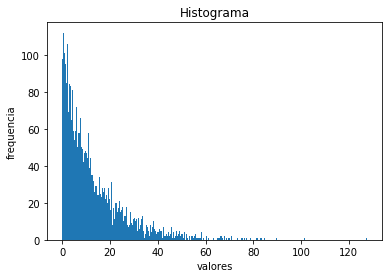

In [17]:
# histograma de llegadas
cuenta, cajas, ignorar = plt.hist(llegadas, 500)
plt.ylabel('frequencia')
plt.xlabel('valores')
plt.title('Histograma')
plt.show()

### Distribución de las piezas

El fichero `E1.piezas.txt` incluye un histórico de piezas que han llegado al taller, que nos permitirá identificar la proporción de piezas que hay de cada uno de los tres tipos. Esta proporción la utilizaremos después en el generador aleatorio de piezas de nuestro simulador.

In [3]:
archivo_piezas = open('./E1.piezas.txt', 'r')
piezas = [int(line) for line in archivo_piezas.readlines()]
archivo_piezas.close()
#cantidad de piezas de cada tipo
stats.itemfreq(piezas)

array([[   1, 1254],
       [   2, 2407],
       [   3, 1339]])

## Simulación del Sistema

**#TODO: imagen del sistema**
Asumimos FIFO para cada celula de procesamiento.
También explicar que los transportes entre las distintas células deberían ser tomados como si de otro servicio se tratase y por lo tanto ser nodos en la red. En ellos ninguna pieza espera a ser transportada, ya que estos nodos tienen infinitos servidores y por lo tanto, no tienen cola. Debido a esto, para simplificar el código y nuestro sistema hemos decidido no tratar el transporte entre nodos como otro nodo. **##TODO: ¿veis bien decir esto?##**

A continuación se muestra el código de nuestro simulador.

In [1]:
import numpy as np
import random
import queue
import math

Este es nuestro generador aleatorio de tiempos de llegada de las piezas. Son generados con una distribución exponencial con los parametros obtenidos en el contraste realizado anteriormente. Para ello utilizamos `numpy.random.exponential`.

In [2]:
# times = [1,2,200]

def genArrival():
    return np.random.exponential(13)
    # debug
    global times
    time = times[0]
    times = times[1:]
    return time

El tipo de pieza se generará de forma aleatoria, pero siguiendo la proporción que muestra el archivo `E1.piezas.txt` que se nos entrega con el enunciado.

In [3]:
def genPieceType():
    x = np.random.random()
    if x < 0.2508: # 1254/5000
        return 1
    elif x < 0.7322: # (1254+2407)/5000
        return 2
    else: # x < 1 (1254+2407+1339)
        return 3
# TODO: use 0.25, 0.5, 0.25 instead?

Como nos indica el enunciado los tiempos de procesado de cada pieza en cada célula siguen una distribución triangular de los tiempos expresados en minutos de la tabla del enunciado. Para ello utilizamos `numpy.random.triangular`.

In [7]:
class System():
    
    def __init__(self, transportTime, num_machines):
        self.eventsQueue = queue.PriorityQueue()
        
        #if debug:
        #    self.arrivals = open("E1.llegadas.txt","r")
        #    self.pieces = open("E1.piezas.txt","r")
        # open files
        
        # fabrication sequence for each type of piece
        self.steps = [[0,1,2,3],
                      [0,1,3,1,2],
                      [1,0,2]]
        
        # processing times for each type of piece at each step of its phabrication sequence
        self.processingTimes =[[(6,9,10), (5,8,10), (15,20,25), (8,12,16)],
                           [(1,13,15), (4,6,8), (15,18,21), (6,9,12), (27,30,39)], # El 30 es un 3 en el enunciado, errata
                           [(7,9,11), (7,10,13), (18,23,28)]]
        
        
        # cell queues
        self.queue = [queue.Queue(),queue.Queue(),queue.Queue(),queue.Queue()]
        
        # number of machines in each cell
        self.num_machines = num_machines
        
        # number of idle machines in each clell
        self.idle_machines = [[True for j in range(num_machines[i])] for i in range(4)]
        
        # transportation time between cells
        self.transportTime = transportTime
        
        # stats counters
        self.minTime = [math.inf, math.inf, math.inf] # min processing type of each type of piece
        self.maxTime = [0,0,0] # max processing type of each type of piece
        self.sumTimes = [0,0,0] # Sum of the processing times of all pieces for each type of piece
        self.numPieces = [0,0,0] # Total number of pieces processed for each type of piece
        
        # like the area under the integral of the size of each queue over time, but discrete
        self.queueSizeOverTime = [0,0,0,0] 
        self.lastUpdate = [0,0,0,0] # Last time the previous counter was updated
        
        self.idleTime = [[0 for j in range(num_machines[i])] for i in range(4)] # total time the
                                                            # machine j in cell i have been idle
        self.lastUpdateMachine = [[0 for j in range(num_machines[i])] for i in range(4)] # Last time
                                                                    # the previous counter was updated
        
        self.debug = False
        
    # destructor
        # close files

    def simul_main(self,simulationTime):
    
        self.time = 0
        
        self.simulationTime = simulationTime
        
        self.nextPiece()
    
        while not self.eventsQueue.empty():
            self.time, _, nextEvent = self.eventsQueue.get()
            nextEvent()
            
    def simul_main_debug(self, simulationTime):
            
        self.time = 0
    
        self.simulationTime = simulationTime
    
        self.nextPiece()
            
    def debug_step(self):
        
        if not self.eventsQueue.empty():
            self.time, eventDescription, nextEvent = self.eventsQueue.get()
            print(self.time)
            print(eventDescription)
            nextEvent()
        
    def nextPiece(self):
        nextArrival = self.timeTillNextArrival()
        nextArrivalTime = self.time + nextArrival
        if nextArrivalTime < self.simulationTime:
            nextPieceType = self.nextPieceType()
            nextPiece = (nextArrivalTime, nextPieceType, 0)
            #eventsQueue.put(self.advancePiece(nextPiece), nextArrivalTime)
            #eventsQueue.put(self.nextPiece(), nextArrivalTime)
            # The prority queue as it is breaks if two events happen at the same time
            eventDescription = "piece " + str(nextPiece) + " arrives"
            event = lambda : self.arrivePiece(nextPiece)
            self.eventsQueue.put((nextArrivalTime, eventDescription, event))
    
    def arrivePiece(self,piece):
        self.nextPiece()
        self.advancePiece(piece)
        
    def nextPieceType(self):
        #if debug:
        #    piece = self.pieces.readline()
        #    return int(piece)-1
        #else:
            return genPieceType()-1
        # Types of pieces are shifted so that the first one is 0
        
    def timeTillNextArrival(self):
        #if debug:
        #    arrival = self.arrivals.readline()
        #    return float(arrival)
        #else:
            return genArrival()
    
    def advancePiece(self,piece):
        
        arrivalTime, pieceType, step = piece

        if self.steps[pieceType][step:] == []:
            self.finishPiece(piece)
            if self.debug:
                print("piece " + str(arrivalTime) + " finishes")
        else:
            next_cell = self.steps[pieceType][step]
            if step == 0:
                self.enter(next_cell,piece)
            else:
                eventTime = self.time + self.transportTime
                eventDescription = "piece " + str(piece) + " enters cell " + str(next_cell)
                event = lambda : self.enter(next_cell,piece)
                self.eventsQueue.put((eventTime, eventDescription, event))
    
    def finishPiece(self,piece):
        
        arrivalTime, pieceType, _ = piece
        
        totalTime = self.time - arrivalTime
        
        if totalTime < self.minTime[pieceType]: # use dictionaries, since index needs shifting
            self.minTime[pieceType] = totalTime
       
        if totalTime > self.maxTime[pieceType]:
            self.maxTime[pieceType] = totalTime
        
        self.sumTimes[pieceType] += totalTime
        
        self.numPieces[pieceType] += 1
        
    
    def enter(self,cell,piece):
        
        for machine in range(self.num_machines[cell]):
            if self.idle_machines[cell][machine]:
                self.process(cell,piece,machine)
                return
            
        self.queueSizeOverTime[cell] += self.queue[cell].qsize()*(self.time-self.lastUpdate[cell])
        self.lastUpdate[cell] = self.time
        self.queue[cell].put(piece)

    def process(self,cell,piece,machine):
        
        self.idleTime[cell][machine] += self.time - self.lastUpdateMachine[cell][machine]
        self.lastUpdateMachine[cell][machine] = self.time
        
        _, pieceType, step = piece
        
        low, mode, upp = self.processingTimes[pieceType][step]
        
        if self.debug:
            processing_time = mode
        else:
            processing_time = np.random.triangular(low,mode,upp)
        
        
        self.idle_machines[cell][machine] = False
        
        eventDescription = "piece " + str(piece) + " done in cell " + str(cell)
        self.eventsQueue.put((self.time+processing_time, eventDescription, lambda : self.done(cell,piece,machine)))
        
    def done(self,cell,piece,machine):
        
        self.lastUpdateMachine[cell][machine] = self.time
        
        self.idle_machines[cell][machine] = True
        
        if not self.queue[cell].empty():
            
            self.queueSizeOverTime[cell] += self.queue[cell].qsize()*(self.time-self.lastUpdate[cell])
            self.lastUpdate[cell] = self.time
            nextPiece = self.queue[cell].get()
            self.process(cell,nextPiece,machine)
        
        arrivalTime, pieceType, step = piece
        piece = arrivalTime, pieceType, step + 1
        self.advancePiece(piece)

Vamos a probar nuestro simulador durante 60 minutos y mostraremos la traza de la ejecución del simulador, así como los estadísticos calculados para este tiempo, con el fin de comprobar que el simulador funciona como se espera.
Para iniciar nuestro simulador necesitamos llamar a `System` pasandole como parametros el tiempo de transporte entre células en minutos (en este caso dos minutos) y una tupla especificando el número de máquinas de procesado en cada célula. En nuestro caso una máquina para cada célula, salvo la tercera, que dispone de dos.

In [8]:
system = System(2,[1,1,2,1])
system.simul_main_debug(60)
system.debug = True
for _ in range(500):
    system.debug_step()

7.885280576444816
piece (7.885280576444816, 1, 0) arrives
18.78891806592684
piece (18.78891806592684, 0, 0) arrives
20.885280576444817
piece (7.885280576444816, 1, 0) done in cell 0
22.885280576444817
piece (7.885280576444816, 1, 1) enters cell 1
28.885280576444817
piece (7.885280576444816, 1, 1) done in cell 1
29.885280576444817
piece (18.78891806592684, 0, 0) done in cell 0
30.885280576444817
piece (7.885280576444816, 1, 2) enters cell 3
31.885280576444817
piece (18.78891806592684, 0, 1) enters cell 1
39.88528057644481
piece (18.78891806592684, 0, 1) done in cell 1
41.88528057644481
piece (18.78891806592684, 0, 2) enters cell 2
48.88528057644481
piece (7.885280576444816, 1, 2) done in cell 3
50.88528057644481
piece (7.885280576444816, 1, 3) enters cell 1
52.93413576729
piece (52.93413576729, 2, 0) arrives
57.86273217655983
piece (57.86273217655983, 0, 0) arrives
59.88528057644481
piece (7.885280576444816, 1, 3) done in cell 1
61.88528057644481
piece (18.78891806592684, 0, 2) done in 

In [13]:
print("Tiempo (m) de ejecución de la simulación = %s" %system.time)
print("Tiempo (m) mínimo de fabricación para cada tipo de pieza = %s" %system.minTime)#TODO: asegurarse de que es tiempo de fabricacion y no de procesado
print("Tiempo (m) máximo de fabricación para cada tipo de pieza = %s" %system.maxTime)#TODO: lo mismo
print("Suma de los tiempos (m) de procesamiento de todas las piezas de cada tipo = %s" %system.sumTimes)
print("Cantidad de piezas fabricadas de cada tipo = %s" %system.numPieces)
print("Tiempo (m) medio de fabricación para cada tipo de pieza = %s" %[system.sumTimes[i]/system.numPieces[i] for i in range(3)])
print("Número medio de piezas esperando en cada célula = %s" %[system.queueSizeOverTime[i]/system.time for i in range(4)])
print("Tiempo (m) que están ociosas las células = %s" %system.idleTime)

Tiempo (m) de ejecución de la simulación = 149.96994992428463
Tiempo (m) mínimo de fabricación para cada tipo de pieza = [64.30272637893005, 110.57570217895518, 46.0]
Tiempo (m) máximo de fabricación para cada tipo de pieza = [96.96464497920343, 110.57570217895518, 80.95904122021857]
Suma de los tiempos (m) de procesamiento de todas las piezas de cada tipo = [418.14985257379857, 110.57570217895518, 126.95904122021857]
Cantidad de piezas fabricadas de cada tipo = [5, 1, 2]
Tiempo (m) medio de fabricación para cada tipo de pieza = [83.62997051475972, 110.57570217895518, 63.47952061010928]
Número medio de piezas esperando en cada célula = [1.0250423823597004, 0.03306689922029198, 0.08001602991838327, 0.2267120847687526]
Tiempo (m) que están ociosas las células = [80.96994992428463, 53.96994992428463, 109.93989984856927, 130.96994992428463]


Observando la traza y las estadísticas comprobamos que funciona como se espera.

In [252]:
system.idleTime # TODO: fix

[832.6736934616771, 827.4331821415414, 1485.9400048702266, 0]

### Apartado A: Tiempo de transporte = 2 min.

En este apartado simulamos el comportamiento del sistema durante 2 meses, suponiendo que el taller trabaja de forma ininterrumpida, y calculamos el tiempo mínimo, medio y máximo que tardan en fabricarse los tres tipos de piezas, el número medio de piezas esperando en cada una de las 4 células y la proporción de tiempo que están ociosas las máquinas de procesado de las células.

In [9]:
system = System(2,[1,1,2,1])
system.simul_main(86400) # 2 months

In [11]:
print("Tiempo (m) de ejecución de la simulación = %s" %system.time)
print("Tiempo (m) mínimo de fabricación para cada tipo de pieza = %s" %system.minTime)#TODO: asegurarse de que es tiempo de fabricacion y no de procesado
print("Tiempo (m) máximo de fabricación para cada tipo de pieza = %s" %system.maxTime)#TODO: lo mismo
print("Cantidad de piezas fabricadas de cada tipo = %s" %system.numPieces)
print("Tiempo (m) medio de fabricación para cada tipo de pieza = %s" %[system.sumTimes[i]/system.numPieces[i] for i in range(3)])
print("Número medio de piezas esperando en cada célula = %s" %[system.queueSizeOverTime[i]/system.time for i in range(4)])
print("Tiempo (m) que están ociosas las células = %s" %system.idleTime)

Tiempo (m) de ejecución de la simulación = 87907.49991965837
Tiempo (m) mínimo de fabricación para cada tipo de pieza = [48.56164307391737, 78.04369889813825, 42.37487462588393]
Tiempo (m) máximo de fabricación para cada tipo de pieza = [1488.4619281110063, 1690.9455530265259, 1476.564672684719]
Cantidad de piezas fabricadas de cada tipo = [1665, 3159, 1729]
Tiempo (m) medio de fabricación para cada tipo de pieza = [427.81747732124563, 483.17901659454543, 383.0134946453175]
Número medio de piezas esperando en cada célula = [0.7911889652837257, 2.3984785605642, 22.448689418444435, 2.462436966774386]
Tiempo (m) que están ociosas las células = [[24669.663520789378], [10707.20744094884], [722.3956639669261, 1126.3989635175267], [10916.463647213386]]


In [49]:
system.idleTime # TODO: fix

[68848.28091819512, 76623.89639972759, 88731.43893006715, 80413.26636371735]

### Apartado B: Tiempo de transporte = 1 min.

In [18]:
system = System(1,[1,1,2,1])
system.simul_main(86400) # 2 months
print("Tiempo (m) de ejecución de la simulación = %s" %system.time)
print("Tiempo (m) mínimo de fabricación para cada tipo de pieza = %s" %system.minTime)#TODO: asegurarse de que es tiempo de fabricacion y no de procesado
print("Tiempo (m) máximo de fabricación para cada tipo de pieza = %s" %system.maxTime)#TODO: lo mismo
print("Suma de los tiempos (m) de procesamiento de todas las piezas de cada tipo = %s" %system.sumTimes)
print("Cantidad de piezas fabricadas de cada tipo = %s" %system.numPieces)
print("Tiempo (m) medio de fabricación para cada tipo de pieza = %s" %[system.sumTimes[i]/system.numPieces[i] for i in range(3)])
print("Número medio de piezas esperando en cada célula = %s" %[system.queueSizeOverTime[i]/system.time for i in range(4)])
print("Tiempo (m) que están ociosas las células = %s" %system.idleTime)

Tiempo (m) de ejecución de la simulación = 88856.71365851162
Tiempo (m) mínimo de fabricación para cada tipo de pieza = [51.010011284997375, 78.07123796300812, 40.686200954532524]
Tiempo (m) máximo de fabricación para cada tipo de pieza = [2547.6993139878905, 2682.164793932956, 2454.995370667937]
Suma de los tiempos (m) de procesamiento de todas las piezas de cada tipo = [1986097.0570824686, 3969618.535224857, 2023209.0407812332]
Cantidad de piezas fabricadas de cada tipo = [1664, 3207, 1807]
Tiempo (m) medio de fabricación para cada tipo de pieza = [1193.5679429582144, 1237.798108894561, 1119.6508250034494]
Número medio de piezas esperando en cada célula = [0.8612970730980438, 2.855510003322014, 78.75402562243715, 2.635572180616627]
Tiempo (m) que están ociosas las células = [69060.91878420078, 76430.10944418923, 88585.1678539692, 79020.22656601395]


## Máquina de procesado adicional

Dice antonio que calculemos las mismas estadísticas que en el apartado anterior y eligamos la mejor solución en base a esas estadísticas. Si no hay solución de pareto, discutir las mejores soluciones

In [12]:
np.random.seed(0)

In [13]:
system = System(2,[2,1,2,1])
system.simul_main(86400)

In [14]:
system.time

89382.39784571007

In [15]:
np.random.seed(0)

In [16]:
system = System(2,[1,2,2,1])
system.simul_main(86400)

In [17]:
system.time

87887.80376318807

In [18]:
np.random.seed(0)

In [19]:
system = System(2,[1,1,3,1])
system.simul_main(86400)

In [21]:
system.time

86473.14191322502

In [22]:
np.random.seed(0)

In [23]:
system = System(2,[1,1,2,2])
system.simul_main(86400)

In [24]:
system.time

90978.78410476734